In [ ]:
import fitz  # PyMuPDF

# Specify your input PDF and image file paths
pdf_document = r"D:\World Bank\Data-Portal-Brief-Generator\Briefs\Cameroon\Cameroon.pdf"
image_file = r"D:\World Bank\Data-Portal-Brief-Generator\Sources\Header Images\Headers pngs\03-1-HCCB-ALB.png"  # Replace with your image file

# Open the existing PDF
doc = fitz.open(pdf_document)

# Get the dimensions of the image
img = fitz.open(image_file)
img_width, img_height = img[0].rect.width, img[0].rect.height
img.close()

# Overlay the image on each page
for page_number in range(len(doc)):
    page = doc[page_number]
    # Get the page dimensions
    page_width = page.rect.width
    page_height = page.rect.height

    # Calculate the rectangle where the image will be placed
    # This example scales the image to fit the width of the page
    img_rect = fitz.Rect(
        0,  # x0: left side of the page
        0,  # y0: top of the page
        page_width,  # x1: right side of the page
        img_height * (page_width / img_width)  # y1: maintain aspect ratio
    )

    # Insert the image into the page
    page.insert_image(img_rect, filename=image_file)

# Save the modified PDF to a new file
output_pdf = r"D:\World Bank\Data-Portal-Brief-Generator\output.pdf"
doc.save(output_pdf)

print(f"Header image has been successfully added to '{output_pdf}'.")


In [2]:
!pip install pandasdmx

  Obtaining dependency information for pandasdmx from https://files.pythonhosted.org/packages/12/15/366ac0693b489399c6c43eff9f80a3f8fef53faa848bf0e885d4f16a2d0c/pandasdmx-1.10.0-py3-none-any.whl.metadata
  Obtaining dependency information for pydantic<2.0,>=1.9.2 from https://files.pythonhosted.org/packages/ee/79/4b1be8350bd9755a895fad95a0152bf771d3bad272f7385809b2503baf42/pydantic-1.10.17-cp311-cp311-win_amd64.whl.metadata
     ---------------------------------------- 0.0/153.0 kB ? eta -:--:--
     -------------------------------------- 153.0/153.0 kB 8.9 MB/s eta 0:00:00
Using cached pandasdmx-1.10.0-py3-none-any.whl (88 kB)
   ---------------------------------------- 0.0/2.1 MB ? eta -:--:--
   ---------- ----------------------------- 0.6/2.1 MB 8.9 MB/s eta 0:00:01
   ---------------------------- ----------- 1.5/2.1 MB 10.7 MB/s eta 0:00:01
   ---------------------------------------  2.1/2.1 MB 10.3 MB/s eta 0:00:01
   ---------------------------------------- 2.1/2.1 MB 8.0 MB/s e


[notice] A new release of pip is available: 23.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import API_access as api

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandasdmx\remote.py:11: RuntimeWarning: optional dependency requests_cache is not installed; cache options to Session() have no effect
  warn(


In [18]:
def drops_irrelevant_index_levels(df):

    indicator_0_to_5_years = [
        "NT_ANT_HAZ_NE2",
        "NT_ANT_WHZ_NE2",
        "NT_ANT_WHZ_NE3",
        "NT_ANT_WHZ_PO2",
        "NT_BF_EXBF",
    ]
    indicator_6_to_23_months = ["NT_CF_MMF"]
    indicator_36_to_59_months = ["ECD_CHLD_36-59M_LMPSL"]
    indicator_15_to_49_years = [
        "MNCH_ANC1",
        "MNCH_ANC4",
        "MNCH_DEMAND_FP",
        "MNCH_PNCMOM",
        "MNCH_SAB",
        "MNCH_ITNPREG",
    ]
    indicator_18_to_29_years = [
        "PT_M_18-29_SX-V_AGE-18",
        "PT_F_18-29_SX-V_AGE-18",
    ]
    indicator_15_to_24_years = [
        "HVA_PREV_KNOW",
        "HVA_PREV_KNOW_TEST",
        "HVA_PREV_CNDM_MULT",
    ]

    # Replace COUNTRY with REF_AREA (SDMX standard)
    df.index.names = ["REF_AREA" if idx == "COUNTRY" else idx for idx in df.index.names]

    indicador = df.index.get_level_values("INDICATOR").unique().values[0]
    indexes = df.index.names
    irrelevant_indexes = [
        idx
        for idx in indexes
        if idx not in ["REF_AREA", "INDICATOR", "TIME_PERIOD", "SEX", "DATA_SOURCE"]
    ]

    for idx in irrelevant_indexes:
        totals_mask = df.index.get_level_values(idx) == "_T"
        if totals_mask.sum() > 0:
            df = df[totals_mask].droplevel(idx)
        elif idx == "AGE":
            if indicador in indicator_0_to_5_years:
                df = df[df.index.get_level_values("AGE").isin(["Y0T4", "M0T5"])]
            elif indicador in indicator_6_to_23_months:
                df = df[df.index.get_level_values("AGE") == "M6T23"]
            elif indicador in indicator_36_to_59_months:
                df = df[df.index.get_level_values("AGE") == "M36T59"]
            elif indicador in indicator_15_to_49_years:
                df = df[df.index.get_level_values("AGE") == "Y15T49"]
            elif indicador in indicator_18_to_29_years:
                df = df[df.index.get_level_values("AGE") == "Y18T29"]
            elif indicador in indicator_15_to_24_years:
                df = df[df.index.get_level_values("AGE") == "Y15T24"]
            else:
                df = df.droplevel(idx)
        else:
            df = df.droplevel(idx)

    assert df.index.duplicated().sum() == 0, "There are duplicated rows."
    return df


In [19]:
drops_irrelevant_index_levels(df)

value
REF_AREA INDICATOR             SEX AGE    TIME_PERIOD      
AFG      ECD_CHLD_36-59M_LMPSL F   M36T59 2023         30.8
                               M   M36T59 2023         27.9
                               _T  M36T59 2023         29.3
ARG      ECD_CHLD_36-59M_LMPSL F   M36T59 2020         87.4
                               M   M36T59 2020         85.1
...                                                     ...
WSM      ECD_CHLD_36-59M_LMPSL M   M36T59 2020         70.4
                               _T  M36T59 2020         73.3
ZWE      ECD_CHLD_36-59M_LMPSL F   M36T59 2019         73.5
                               M   M36T59 2019         68.1
                               _T  M36T59 2019         70.8

[238 rows x 1 columns]

In [6]:
cl_ref_areas = api.get_county_codes()
df = api.query_indicator("ECD_CHLD_36-59M_LMPSL", "ECD")

drops_irrelevant_index_levels(df)

AssertionError: There are duplicated rows.

In [1]:

def list_files_in_directory(folder_path):
    file_list = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_list.append(os.path.join(root, file))
    return file_list


def resize_image(image, new_width):
    old_width = image.size[0]
    old_height = image.size[1]
    new_height = int(old_height * (new_width / old_width))
    return image.resize((new_width, new_height)), new_height


def add_header_and_footer(background, header, footer):
    # Resize the header and footer images to match the background size
    new_width = background.size[0] + 2
    header, new_height = resize_image(header, new_width)
    footer, new_height = resize_image(footer, new_width)

    # Create a new image with transparency
    merged_image = Image.new("RGB", background.size)

    # Paste the background image onto the new image
    merged_image.paste(background, (0, 0))

    # Paste the footer image onto the new image, using the alpha channel of the footer
    merged_image.paste(footer, (-1, background.size[1] - new_height + 2), mask=footer)
    merged_image.paste(header, (-1, -1), mask=header)

    return merged_image

In [3]:
from pdf2image import convert_from_path
from PIL import Image
import os

Image.MAX_IMAGE_PIXELS = 1000000000 


wbcode = "AUS"
wbcountryname = "Australia"

briefs = r"D:\Laboral\World Bank\Data-Portal-Brief-Generator\Briefs"
sources = r"D:\Laboral\World Bank\Data-Portal-Brief-Generator\Sources"
headers = list_files_in_directory(rf"{sources}\\Header Images\\Headers pngs")
# pdf = convert_from_path(
#     rf"{briefs}\{wbcountryname}\{wbcountryname}.pdf",
#     size=(1700 * 2.5 * 5, 2200 * 2.5 * 5),
# )  # This returns a list even for a 1 page pdf

# ## P1
# header_path = [header for header in headers if f"1-HCCB-{wbcode}" in header][0]
# header = Image.open(header_path)
# footer = Image.open(rf"{sources}\Footer Images\p1 footer.png")

# page_1 = add_header_and_footer(pdf[0], header, footer)

# ## P2
# header_path = [header for header in headers if f"2-HCCB-{wbcode}" in header][0]
# header = Image.open(header_path)
# footer = Image.open(rf"{sources}\Footer Images\p2 footer.png")

# page_2 = add_header_and_footer(pdf[1], header, footer)

# # Save them
# page_1.save(
#     rf"{briefs}\For print\{wbcountryname}.pdf",
#     "PDF",
#     mode="RGBA",
#     resolution=100.0,
#     save_all=True,
#     append_images=[page_2],
# )
# # images[wbregion] += [page_1, page_2]


In [6]:
done = os.listdir(r"D:\Laboral\World Bank\Data-Portal-Brief-Generator\Briefs\For Print")
done_ctrys = [ctry.split(".")[0] for ctry in done]
done_ctrys

['Australia',
 'Brunei Darussalam',
 'Cambodia',
 'China',
 'Federated States of Micronesia',
 'Fiji',
 'Hong Kong SAR, China',
 'Indonesia',
 'Japan',
 'Kiribati',
 "Lao People's Democratic Republic",
 'Macao SAR, China',
 'Malaysia',
 'Marshall Islands',
 'Mongolia',
 'Myanmar',
 'Nauru',
 'Republic of Korea']

In [4]:
headers

['D:\\Laboral\\World Bank\\Data-Portal-Brief-Generator\\Sources\\\\Header Images\\\\Headers pngs\\02-1-HCCB-AFG.png',
 'D:\\Laboral\\World Bank\\Data-Portal-Brief-Generator\\Sources\\\\Header Images\\\\Headers pngs\\02-2-HCCB-AFG.png',
 'D:\\Laboral\\World Bank\\Data-Portal-Brief-Generator\\Sources\\\\Header Images\\\\Headers pngs\\03-1-HCCB-ALB.png',
 'D:\\Laboral\\World Bank\\Data-Portal-Brief-Generator\\Sources\\\\Header Images\\\\Headers pngs\\03-2-HCCB-ALB.png',
 'D:\\Laboral\\World Bank\\Data-Portal-Brief-Generator\\Sources\\\\Header Images\\\\Headers pngs\\04-1-HCCB-DZA.png',
 'D:\\Laboral\\World Bank\\Data-Portal-Brief-Generator\\Sources\\\\Header Images\\\\Headers pngs\\04-2-HCCB-DZA.png',
 'D:\\Laboral\\World Bank\\Data-Portal-Brief-Generator\\Sources\\\\Header Images\\\\Headers pngs\\05-1-HCCB-AGO.png',
 'D:\\Laboral\\World Bank\\Data-Portal-Brief-Generator\\Sources\\\\Header Images\\\\Headers pngs\\05-2-HCCB-AGO.png',
 'D:\\Laboral\\World Bank\\Data-Portal-Brief-Generator\\

In [7]:
pdf[0].size

(1, 1)

In [3]:
pdf

[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1x1>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1x1>]

In [ ]:
df = df[df.property_type.isin(['Casa','Departamento', 'Casa de campo', 'PH']) & (df.price>=10000) & (df.price<=1000000)]

In [ ]:
import geopandas as gpd

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat))


<Axes: >

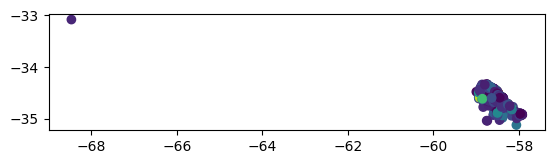

In [83]:
gdf = gdf[gdf.l2.isin(['Capital Federal', 'Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Sur', 'Bs.As. G.B.A. Zona Oeste'])]
# Keep only valid geometries
gdf = gdf[gdf.geometry.is_valid & ~gdf.geometry.is_empty].set_crs(epsg=4326)
gdf.sample(1000).plot(column='price')

In [1]:
import run_model

ModuleNotFoundError: No module named 'run_model'

In [ ]:
import xarray as xr
ds = xr.open_dataset(r"D:\Downloads\bsose_i105_2008to2012_monthly_Mu.nc")

In [ ]:
import matplotlib.pyplot as plt
ds.sel(Z=-2.1, time=ds.time[0], XC=slice(250, 360))['BLGMU'].plot(figsize=(16, 10))
# plt.axis('off')

In [ ]:
try:
    from sfi import Macro

    root = Macro.getGlobal("root")
    data_raw = Macro.getGlobal("data_raw")
    data_processed = Macro.getGlobal("data_processed")
    data_output = Macro.getGlobal("data_output")
    excels = Macro.getGlobal("excels")
    date = Macro.getGlobal("date")  # Date when the full process is run
    extra = Macro.getGlobal(
        "extra"
    )  # Placeholder for testing, just add "_test" or something like that to avoid overwrite db

except:
    root = r"D:\Laboral\World Bank\Data-Portal-Brief-Generator"
    # portal = r"C:\Users\llohi\OneDrive - Universidad Torcuato Di Tella\WB\Data-Portal-Brief-Generator"
    data_raw = rf"{root}\Data\Data_Raw"
    data_processed = rf"{root}\Data\Data_Processed"
    data_output = rf"{root}\Data\Data_Output"
    extra = ""

sources = rf"{root}\Sources"
briefs = rf"{root}\Briefs"
excels = rf"{root}\Datasheets"

import os
import pandas as pd
from tqdm import tqdm
from PIL import Image
from pdf2image import convert_from_path


def list_files_in_directory(folder_path):
    file_list = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            file_list.append(os.path.join(root, file))
    return file_list


def resize_image(image, new_width):
    old_width = image.size[0]
    old_height = image.size[1]
    new_height = int(old_height * (new_width / old_width))
    return image.resize((new_width, new_height)), new_height


def add_header_and_footer(background, header, footer):
    # Resize the header and footer images to match the background size
    new_width = background.size[0] + 2
    header, new_height = resize_image(header, new_width)
    footer, new_height = resize_image(footer, new_width)

    # Create a new image with transparency
    merged_image = Image.new("RGB", background.size)

    # Paste the background image onto the new image
    merged_image.paste(background, (0, 0))

    # Paste the footer image onto the new image, using the alpha channel of the footer
    merged_image.paste(footer, (-1, background.size[1] - new_height + 2), mask=footer)
    merged_image.paste(header, (-1, -1), mask=header)

    return merged_image


df = pd.read_stata(rf"{data_output}\ordered_text.dta")
df = df.sort_values(by=["wbregion", "wbcode"])
# df = df[df.wbcode.isin(["AUT"])]
df = df[df.wbregion == "East Asia & Pacific"]

headers = list_files_in_directory(rf"{sources}\\Header Images\\Headers pngs")
images = {k: [] for k in df.wbregion.unique()}
for country_data in tqdm(df[["wbcode", "wbcountryname", "wbregion"]].itertuples()):
    try:
        wbcode = country_data[1]
        wbcountryname = country_data[2]
        wbregion = country_data[3]

        # print(wbcode)
        pdf = convert_from_path(
            rf"{briefs}\{wbcountryname}\{wbcountryname}{extra}.pdf",
            size=(1700 * 2.5, 2200 * 2.5),
        )  # This returns a list even for a 1 page pdf

        ## P1
        header_path = [header for header in headers if f"1-HCCB-{wbcode}" in header][0]
        header = Image.open(header_path)
        footer = Image.open(rf"{sources}\Footer Images\p1 footer.png")

        page_1 = add_header_and_footer(pdf[0], header, footer)

        ## P2
        header_path = [header for header in headers if f"2-HCCB-{wbcode}" in header][0]
        header = Image.open(header_path)
        footer = Image.open(rf"{sources}\Footer Images\p2 footer.png")

        page_2 = add_header_and_footer(pdf[1], header, footer)

        # Save them
        # page_1.save(
        #     rf"{briefs}\For print\{wbregion}\{wbcountryname}{extra}.pdf",
        #     "PDF",
        #     mode="RGBA",
        #     resolution=100.0,
        #     save_all=True,
        #     append_images=[page_2],
        # )
        images[wbregion] += [page_1, page_2]

    except Exception as exception:
        print(f"Error with {wbcode}: {exception}")

In [ ]:
%tensorboard

In [ ]:
for region, imgs in images.items():
    os.makedirs(rf"{briefs}\For print\{region}_", exist_ok=True)

    imgs[0].save(
        rf"{briefs}\For print\{region}_\{region}_{extra}.pdf",
        "PDF",
        mode="RGBA",
        resolution=100.0,
        save_all=True,
        append_images=imgs[1:],
    )
    imgs = []

### Indicators differences v6 vs v9

In [7]:
import pandas as pd

new_listing = pd.read_stata(r"D:\Laboral\World Bank\Data-Portal-Brief-Generator\Data\Data_Output\listing.dta")
old_listing = pd.read_stata(r"D:\Laboral\World Bank\Data-Portal-Brief-Generator\Data\Data_Output\listing_cortev6.dta")
new_data_briefs = pd.read_stata(r"D:\Laboral\World Bank\Data-Portal-Brief-Generator\Data\Data_Output\data_briefs.dta")
old_data_briefs = pd.read_stata(r"D:\Laboral\World Bank\Data-Portal-Brief-Generator\Data\Data_Output\data_briefs___corte_2015.dta")

In [11]:
dataset = {}

from tqdm import tqdm
import numpy as np

for wbcode in tqdm(new_data_briefs.wbcode.unique()):
    
    new_row = new_listing.loc[new_listing.wbcode==wbcode]    
    country_data = {}
    for stage in range(1,5):
        for position in range(1,4):
            
            indicator = new_row[f'name_{stage}_{position}']
            name = new_row[f'lbl_{stage}_{position}'].values[0]

            ### New listing
            year_new = new_row[f'year_{stage}_{position}'].values[0]
            try:
                value_new = new_data_briefs.loc[(new_data_briefs.wbcode == wbcode), indicator].values[0][0]
            except:
                value_new = np.nan
                year_new = np.nan
            
            ### Previous value
            try:
                year_prev = new_data_briefs.loc[(new_data_briefs.wbcode == wbcode), f"{indicator.values[0]}_year_prev"].values[0]
                value_prev = new_data_briefs.loc[(new_data_briefs.wbcode == wbcode), f"{indicator.values[0]}_prev"].values[0]
            except:
                try:
                    value_prev = new_data_briefs.loc[(new_data_briefs.wbcode == wbcode), f"{indicator.values[0]}_prev"].values[0]
                    print("Aca hay algo raro...")
                except:
                    value_prev = np.nan
                    year_prev = np.nan
            
            
            if np.isnan(value_new):
                value_new = np.nan
                year_new = np.nan
                
            # Store in dict
            country_data[f'{stage}_{position}_name'] = name
            country_data[f'{stage}_{position}_value_new'] = value_new
            country_data[f'{stage}_{position}_value_prev'] = value_prev

            country_data[f'{stage}_{position}_year_new'] = year_new
            country_data[f'{stage}_{position}_year_prev'] = year_prev

   
    dataset[wbcode] = country_data         
    
df = pd.DataFrame().from_dict(dataset, orient='index')

df2 = pd.melt(df.reset_index(), id_vars=["index"], value_vars=df.columns)
df2['position'] = df2.variable.str[:3]
df2['variable'] = df2.variable.str[4:]
df2 = pd.pivot(df2, index=["index", "position"], columns="variable", values="value")
df2            

  0%|          | 0/174 [00:00<?, ?it/s]

100%|██████████| 174/174 [00:13<00:00, 13.29it/s]


variable                                                     name  value_new  \
index position                                                                 
AFG   1_1         Neonatal Mortality rate (per 1,000 live births)  34.087882   
      1_2                    DTP vaccination rate, third dose (%)       69.0   
      1_3                         Postnatal care for newborns (%)       19.3   
      2_1       Child mortality rate (per 1,000 children aged ...   3.981461   
      2_2          Children engaged in child labor (%), ages 5-17        9.0   
...                                                           ...        ...   
ZWE   3_2       Adolescent fertility rate (births per 1,000 wo...  94.311996   
      3_3       Youth not in employment, education or training...       30.4   
      4_1               Female labor force participation rate (%)     66.152   
      4_2                        Life expectancy at birth (years)  59.252998   
      4_3                             Adult unemployment rate (%)      6.342   

variable        value_prev year_new year_prev  
index position                                 
AFG   1_1        39.188015     2021    2016.0  
      1_2             66.0     2022    2017.0  
      1_3              9.3     2018    2015.0  
      2_1           5.3794     2021    2016.0  
      2_2              NaN     2020       NaN  
...                    ...      ...       ...  
ZWE   3_2       100.884003     2021    2016.0  
      3_3             29.4     2021    2019.0  
      4_1        65.747002     2022    2017.0  
      4_2           60.306     2021    2016.0  
      4_3            5.016     2022    2017.0  

[2088 rows x 5 columns]

In [25]:
df2 = df2[~df2.value_new.isna()]
df2['rounded_value'] = df2.value_new.astype(float).round(0)
df2[df2.rounded_value == 0].to_excel(r"D:\Laboral\World Bank\Data-Portal-Brief-Generator\Others\Briefs with 0 values.xlsx")

In [13]:
df2[df2.value_new == 0]

,variable,name,value_new,value_prev,year_new,year_prev
index,position,,,,,


In [67]:
dataset = {}

from tqdm import tqdm
import numpy as np

for wbcode in tqdm(new_data_briefs.wbcode.unique()):
    
    new_row = new_listing.loc[new_listing.wbcode==wbcode]    
    old_row = old_listing.loc[old_listing.wbcode==wbcode]
    country_data = {}
    for stage in range(1,5):
        for position in range(1,4):
            
            indicator = new_row[f'name_{stage}_{position}']
            name = new_row[f'lbl_{stage}_{position}'].values[0]

            ### New listing
            year_new = new_row[f'year_{stage}_{position}'].values[0]
            try:
                value_new = new_data_briefs.loc[(new_data_briefs.wbcode == wbcode), indicator].values[0][0]
            except:
                value_new = np.nan
                year_new = np.nan
            
            ### Previous value
            try:
                year_prev = new_data_briefs.loc[(new_data_briefs.wbcode == wbcode), f"{indicator.values[0]}_year_prev"].values[0]
                value_prev = new_data_briefs.loc[(new_data_briefs.wbcode == wbcode), f"{indicator.values[0]}_prev"].values[0]
            except:
                try:
                    value_prev = new_data_briefs.loc[(new_data_briefs.wbcode == wbcode), f"{indicator.values[0]}_prev"].values[0]
                    print("Aca hay algo raro...")
                except:
                    value_prev = np.nan
                    year_prev = np.nan
            
            ### Old listing
            try:            
                year_old = old_data_briefs.loc[(old_data_briefs.wbcode == wbcode), f"{indicator.values[0]}_year"].values[0]
                value_old = old_data_briefs.loc[(old_data_briefs.wbcode == wbcode), indicator].values[0][0]
            except:
                try:
                    value_old = old_data_briefs.loc[(old_data_briefs.wbcode == wbcode), indicator].values[0][0]
                    print("Aca hay algo raro...")
                except:
                    value_old = np.nan
                    year_old = np.nan
            
            
            if np.isnan(value_new):
                value_new = np.nan
                year_new = np.nan
            if np.isnan(value_old):	
                value_old = np.nan
                year_old = np.nan
                
            # Store in dict
            country_data[f'{stage}_{position}_name'] = name
            country_data[f'{stage}_{position}_value_new'] = value_new
            country_data[f'{stage}_{position}_value_old'] = value_old
            country_data[f'{stage}_{position}_value_dif'] = value_new - value_old
            country_data[f'{stage}_{position}_value_prev'] = value_prev
            country_data[f'{stage}_{position}_value_prev_dif'] = value_new - value_prev

            country_data[f'{stage}_{position}_year_new'] = year_new
            country_data[f'{stage}_{position}_year_old'] = year_old
            country_data[f'{stage}_{position}_year_dif'] = float(year_new) - float(year_old)
            country_data[f'{stage}_{position}_year_prev'] = year_prev
            country_data[f'{stage}_{position}_year_prev_dif'] = float(year_new) - float(year_prev)

   
    dataset[wbcode] = country_data         
    
df = pd.DataFrame().from_dict(dataset, orient='index')
            

100%|██████████| 171/171 [00:06<00:00, 24.98it/s]


In [68]:
pd.set_option('display.max_columns', None)

In [69]:
df2 = pd.melt(df.reset_index(), id_vars=["index"], value_vars=df.columns)
df2['position'] = df2.variable.str[:3]
df2['variable'] = df2.variable.str[4:]
df2 = pd.pivot(df2, index=["index", "position"], columns="variable", values="value")
df2.to_excel(r"D:\Laboral\World Bank\Data-Portal-Brief-Generator\Others\differences_V6_V9-5.xlsx", index=True)

In [70]:
df2[(df2.name == 'Net school enrollment rate, lower secondary (%)') & (df2.value_dif!=0) & (~df2.value_dif.isna())]

,variable,name,value_dif,value_new,value_old,value_prev,value_prev_dif,year_dif,year_new,year_old,year_prev,year_prev_dif
index,position,,,,,,,,,,,
ARG,2_3,"Net school enrollment rate, lower secondary (%)",0.31549,98.12628,97.81079,99.87059,-1.74431,0.0,2020,2020.0,2016.0,4.0
ARM,2_3,"Net school enrollment rate, lower secondary (%)",0.80088,91.21377,90.41289,93.20249,-1.98872,0.0,2021,2021.0,2016.0,5.0
ATG,2_3,"Net school enrollment rate, lower secondary (%)",0.75995,97.48367,96.72372,94.71847,2.7652,0.0,2019,2019.0,2016.0,3.0
AUS,2_2,"Net school enrollment rate, lower secondary (%)",0.13141,97.97814,97.84673,98.90174,-0.9236,0.0,2020,2020.0,2016.0,4.0
BFA,2_3,"Net school enrollment rate, lower secondary (%)",-3.41712,52.60929,56.02641,51.97983,0.62946,0.0,2021,2021.0,2016.0,5.0
BGR,2_3,"Net school enrollment rate, lower secondary (%)",-0.60634,83.43811,84.04445,92.86854,-9.43043,0.0,2020,2020.0,2016.0,4.0
BRA,2_2,"Net school enrollment rate, lower secondary (%)",-1.11498,96.56774,97.68272,96.59925,-0.03151,0.0,2020,2020.0,2016.0,4.0
BTN,2_3,"Net school enrollment rate, lower secondary (%)",-6.34402,86.95628,93.3003,85.58381,1.37247,0.0,2021,2021.0,2016.0,5.0
CHL,2_3,"Net school enrollment rate, lower secondary (%)",0.57842,98.42803,97.84961,96.68023,1.7478,0.0,2020,2020.0,2016.0,4.0


In [ ]:
%tensorboard

In [1]:
import shutil
try:
    from sfi import Macro

    root = Macro.getGlobal("root")
    data_raw = Macro.getGlobal("data_raw")
    data_processed = Macro.getGlobal("data_processed")
    data_output = Macro.getGlobal("data_output")
    excels = Macro.getGlobal("excels")
    date = Macro.getGlobal("date")  # Date when the full process is run
    extra = Macro.getGlobal(
        "extra"
    )  # Placeholder for testing, just add "_test" or something like that to avoid overwrite db

except:
    root = r"D:\World Bank\Data-Portal-Brief-Generator"
    # portal = r"C:\Users\llohi\OneDrive - Universidad Torcuato Di Tella\WB\Data-Portal-Brief-Generator"
    data_raw = rf"{root}\Data\Data_Raw"
    data_processed = rf"{root}\Data\Data_Processed"
    data_output = rf"{root}\Data\Data_Output"
    extra = ""

sources = rf"{root}\Sources"
briefs = rf"{root}\Briefs"
excels = rf"{root}\Datasheets"

import os
import pandas as pd
from tqdm import tqdm
from PIL import Image
from pdf2image import convert_from_path


df = pd.read_stata(rf"{data_output}\ordered_text.dta")

for i, row in df[['wbregion','wbcode', 'wbcountryname']].iterrows():
    region, wbcode, wbcountryname = row[0], row[1], row[2]
    print(region, wbcode)
    os.makedirs(rf"{briefs}\For print\{region}", exist_ok=True)

    shutil.copyfile(
        rf"{briefs}\{wbcountryname}\{wbcountryname}.pdf", 
        rf"{briefs}\For print\{region}\{wbcountryname}.pdf"
)


C:\Users\Nico\AppData\Local\Temp\ipykernel_2328\2457850263.py:37: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region, wbcode, wbcountryname = row[0], row[1], row[2]


Sub-Saharan Africa ZWE
East Asia & Pacific HKG
Sub-Saharan Africa CMR
Sub-Saharan Africa MDG
East Asia & Pacific THA
Europe & Central Asia GBR
Middle East & North Africa YEM
Europe & Central Asia NOR
Sub-Saharan Africa CAF
East Asia & Pacific VUT
Europe & Central Asia MKD
East Asia & Pacific FJI
Europe & Central Asia GRC
East Asia & Pacific SLB
East Asia & Pacific NRU
South Asia LKA
East Asia & Pacific CHN
Sub-Saharan Africa GHA
Latin America & Caribbean GTM
Latin America & Caribbean VCT
Latin America & Caribbean PER
East Asia & Pacific SGP
Europe & Central Asia KAZ
Sub-Saharan Africa SEN
Europe & Central Asia ESP
Latin America & Caribbean MEX
Europe & Central Asia IRL
Latin America & Caribbean HND
Middle East & North Africa KWT
Sub-Saharan Africa AGO
Latin America & Caribbean URY
East Asia & Pacific PHL
Sub-Saharan Africa NER
Sub-Saharan Africa ZAF
Sub-Saharan Africa MWI
Latin America & Caribbean DMA
Sub-Saharan Africa MUS
Sub-Saharan Africa RWA
Latin America & Caribbean SLV
Sub-Sahar

In [89]:
df.wbcountryname.unique()

array(['Zimbabwe', 'Chile', 'Niger', 'The Gambia', 'Italy',
       'Solomon Islands', 'Costa Rica', 'Timor-Leste', 'Slovenia',
       'Nicaragua', 'Fiji', 'Singapore', 'Kiribati', 'Burundi',
       'Bulgaria', 'South Africa', 'Sweden', 'Senegal', 'China',
       'Iceland', 'St. Lucia', 'Pakistan', 'Germany', 'Guyana',
       'Bangladesh', 'Chad', 'Tonga', 'Myanmar', 'Brunei Darussalam',
       'Tajikistan', 'Saudi Arabia', 'Kazakhstan', 'Malawi', 'Mongolia',
       'Bosnia and Herzegovina', 'United Kingdom', 'United States',
       'Côte d’Ivoire', 'Eswatini', 'Mauritania', 'Kuwait', 'Grenada',
       'Tanzania', 'Algeria', 'Mexico', 'Norway', 'Liberia', 'Denmark',
       'Canada', 'Luxembourg', 'West Bank and Gaza', 'Macao SAR, China',
       'Croatia', 'Dominica', 'Tunisia', 'Ethiopia', 'Nigeria', 'Lebanon',
       'Morocco', 'Hungary', 'Australia', 'Estonia',
       'Trinidad and Tobago', 'Nauru', 'St. Kitts and Nevis', 'Kenya',
       'Botswana', 'South Sudan', 'Israel', 'Albania',

In [1]:
import xlwings

In [82]:
wbcode[1]

'RUS'

In [73]:
df[['wbregion','wbcode']]

,wbcode,wbcountryname,wbregion,wbincomegroup,ECedu_year,HIV_inc_1019_year,HPV_vac_year,ITN_children_year,asr_year,b_hygiene_health_year,b_hygiene_sch_year,b_sanit_health_year,b_sanitation_sch_year,breastf_year,care_year,care_febr_child_year,caremother_year,ch_ontrack_year,child_labor_year,diarrhoea_year,eip_neet_mf_y_year,emp_2wap_f_a_year,emp_2wap_m_a_year,emp_nifl_a_year,emp_nifl_y_year,eyrs_year,hci_year,hci_f_year,hci_lower_year,hci_m_year,hci_upper_year,high_skill_year,hypertension_year,insbirths_year,lastnm_afr_year,lastnm_birth_reg_year,lastnm_mmrt_year,lastnm_ter_ger_year,mealfreq_year,met_fam_plan_year,minprof_m_endprim_year,minprof_r_endprim_year,mort1524_year,mort514_year,neomort_year,netenrt_ls_year,nostu_year,obesity_year,org_learning_year,outschool_rate_year,probdeath_ncd_year,psurv_year,qeyrs_year,repetition_year,se_lpv_prim_year,sp_dyn_le00_in_year,stillbirths_year,suicide_15_19_year,test_year,u5_anaemia_year,u5_pneu_cs_year,uhci_year,uhci_f_year,uhci_m_year,uiscr1_year,uiscr2_year,uiscr3_year,uisger02_year,uisoaepg1_year,uisoaepg2gpv_year,uisqutp1_year,uisqutp2t3_year,uisschbsp1welec_year,une_2eap_mf_a_year,une_2eap_mf_y_year,unicef_sanitation_year,vacBCG_year,vacDTP3_year,youth_adult_un_year,youth_lit_year,ECedu_year_prev,HIV_inc_1019_year_prev,HPV_vac_year_prev,ITN_children_year_prev,asr_year_prev,b_hygiene_health_year_prev,b_hygiene_sch_year_prev,b_sanit_health_year_prev,b_sanitation_sch_year_prev,breastf_year_prev,care_year_prev,care_febr_child_year_prev,caremother_year_prev,ch_ontrack_year_prev,child_labor_year_prev,diarrhoea_year_prev,eip_neet_mf_y_year_prev,emp_2wap_f_a_year_prev,emp_2wap_m_a_year_prev,emp_nifl_a_year_prev,emp_nifl_y_year_prev,eyrs_year_prev,hci_year_prev,hci_f_year_prev,hci_lower_year_prev,hci_m_year_prev,hci_upper_year_prev,high_skill_year_prev,hypertension_year_prev,insbirths_year_prev,lastnm_afr_year_prev,lastnm_birth_reg_year_prev,lastnm_mmrt_year_prev,lastnm_ter_ger_year_prev,mealfreq_year_prev,met_fam_plan_year_prev,minprof_m_endprim_year_prev,minprof_r_endprim_year_prev,mort1524_year_prev,mort514_year_prev,neomort_year_prev,netenrt_ls_year_prev,nostu_year_prev,obesity_year_prev,org_learning_year_prev,outschool_rate_year_prev,probdeath_ncd_year_prev,psurv_year_prev,qeyrs_year_prev,repetition_year_prev,se_lpv_prim_year_prev,sp_dyn_le00_in_year_prev,stillbirths_year_prev,suicide_15_19_year_prev,test_year_prev,u5_anaemia_year_prev,u5_pneu_cs_year_prev,uhci_year_prev,uhci_f_year_prev,uhci_m_year_prev,uiscr1_year_prev,uiscr2_year_prev,uiscr3_year_prev,uisger02_year_prev,uisoaepg1_year_prev,uisoaepg2gpv_year_prev,uisqutp1_year_prev,uisqutp2t3_year_prev,uisschbsp1welec_year_prev,une_2eap_mf_a_year_prev,une_2eap_mf_y_year_prev,unicef_sanitation_year_prev,vacBCG_year_prev,vacDTP3_year_prev,youth_adult_un_year_prev,youth_lit_year_prev,ECedu,HIV_inc_1019,HPV_vac,ITN_children,asr,b_hygiene_health,b_hygiene_sch,b_sanit_health,b_sanitation_sch,breastf,care,care_febr_child,caremother,ch_ontrack,child_labor,diarrhoea,eip_neet_mf_y,emp_2wap_f_a,emp_2wap_m_a,emp_nifl_a,emp_nifl_y,eyrs,hci,hci_f,hci_lower,hci_m,hci_upper,high_skill,hypertension,insbirths,lastnm_afr,lastnm_birth_reg,lastnm_mmrt,lastnm_ter_ger,mealfreq,met_fam_plan,minprof_m_endprim,minprof_r_endprim,mort1524,mort514,neomort,netenrt_ls,nostu,obesity,org_learning,outschool_rate,probdeath_ncd,psurv,qeyrs,repetition,se_lpv_prim,sp_dyn_le00_in,stillbirths,suicide_15_19,test,u5_anaemia,u5_pneu_cs,uhci,uhci_f,uhci_m,uiscr1,uiscr2,uiscr3,uisger02,uisoaepg1,uisoaepg2gpv,uisqutp1,uisqutp2t3,uisschbsp1welec,une_2eap_mf_a,une_2eap_mf_y,unicef_sanitation,vacBCG,vacDTP3,youth_adult_un,youth_lit,ECedu_prev,HIV_inc_1019_prev,HPV_vac_prev,ITN_children_prev,asr_prev,b_hygiene_health_prev,b_hygiene_sch_prev,b_sanit_health_prev,b_sanitation_sch_prev,breastf_prev,care_prev,care_febr_child_prev,caremother_prev,ch_ontrack_prev,child_labor_prev,diarrhoea_prev,eip_neet_mf_y_prev,emp_2wap_f_a_prev,emp_2wap_m_a_prev,emp_nifl_a_prev,emp_nifl_y_prev,eyrs_prev,h

In [71]:
df2[(df2.value_dif!=0) & (~df2.value_dif.isna())].name.unique()

array(['Female labor force participation rate (%)',
       'Adult unemployment rate (%)',
       'Primary school completion rate (%)\xa0',
       'Net school enrollment rate, lower secondary (%)',
       'Adolescent fertility rate (births per 1,000 women), ages 15-19',
       'Life expectancy at birth (years)', 'Youth unemployment rate (%)',
       'Out of school children, primary (%)',
       'Pre-primary school gross enrollment ratio (%)',
       'Lower secondary school completion rate (%)',
       'Probability of dying from NCDs (%)',
       'Gross school enrollment rate, tertiary (%)'], dtype=object)

In [63]:
changed_briefs = []
for col in [col for col in df.columns if "year_dif" in col]:
    changed_briefs += [df[df[col]!=0].index.to_series()]

briefs_that_changed = pd.concat(changed_briefs).unique()
briefs_that_changed.sort()
briefs_that_changed

array(['AGO', 'ALB', 'ARE', 'ARG', 'ARM', 'ATG', 'AUS', 'AUT', 'AZE',
       'BDI', 'BEL', 'BEN', 'BFA', 'BGD', 'BGR', 'BHR', 'BIH', 'BLR',
       'BRA', 'BRN', 'BTN', 'BWA', 'CAF', 'CAN', 'CHE', 'CHL', 'CHN',
       'CIV', 'CMR', 'COG', 'COL', 'COM', 'CRI', 'CYP', 'CZE', 'DEU',
       'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'ESP', 'EST', 'ETH', 'FIN',
       'FJI', 'FRA', 'GAB', 'GBR', 'GEO', 'GHA', 'GIN', 'GMB', 'GRC',
       'GRD', 'GTM', 'GUY', 'HKG', 'HND', 'HRV', 'HTI', 'HUN', 'IDN',
       'IND', 'IRL', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JOR', 'JPN',
       'KAZ', 'KEN', 'KGZ', 'KHM', 'KIR', 'KNA', 'KWT', 'LBN', 'LBR',
       'LCA', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAC', 'MAR', 'MDA',
       'MDG', 'MEX', 'MHL', 'MLI', 'MLT', 'MNG', 'MOZ', 'MRT', 'MUS',
       'MWI', 'MYS', 'NAM', 'NER', 'NGA', 'NIC', 'NLD', 'NOR', 'NPL',
       'NRU', 'NZL', 'OMN', 'PAK', 'PAN', 'PER', 'PHL', 'PLW', 'PNG',
       'POL', 'PRT', 'PRY', 'QAT', 'RWA', 'SAU', 'SDN', 'SEN', 'SGP',
       'SLB', 'SLE',

In [11]:
stage = 2
position = 3
new_listing.iloc[5,:][f'name_{stage}_{position}']

'netenrt_ls'

In [1]:
try:
    from sfi import Macro

    root = Macro.getGlobal("root")
    data_raw = Macro.getGlobal("data_raw")
    data_processed = Macro.getGlobal("data_processed")
    data_output = Macro.getGlobal("data_output")
    excels = Macro.getGlobal("excels")
    date = Macro.getGlobal("date")  # Date when the full process is run
    extra = Macro.getGlobal(
        "extra"
    )  # Placeholder for testing, just add "_test" or something like that to avoid overwrite db

except:
    root = r"D:\Laboral\World Bank\Data-Portal-Brief-Generator"
    # portal = r"C:\Users\llohi\OneDrive - Universidad Torcuato Di Tella\WB\Data-Portal-Brief-Generator"
    data_raw = rf"{root}\Data\Data_Raw"
    data_processed = rf"{root}\Data\Data_Processed"
    data_output = rf"{root}\Data\Data_Output"
    extra = ""

sources = rf"{root}\Sources"
briefs = rf"{root}\Briefs"
excels = rf"{root}\Datasheets"

import os
import pandas as pd
from tqdm import tqdm
from PIL import Image
from pdf2image import convert_from_path

df = pd.read_stata(rf"{data_output}\ordered_text.dta")
df = df.sort_values(by=["wbregion", "wbcode"])


In [5]:
df.wbcode.unique()

array(['AUS', 'BRN', 'CHN', 'FJI', 'FSM', 'HKG', 'IDN', 'JPN', 'KHM',
       'KIR', 'KOR', 'LAO', 'MAC', 'MHL', 'MMR', 'MNG', 'MYS', 'NRU',
       'NZL', 'PHL', 'PLW', 'PNG', 'SGP', 'SLB', 'THA', 'TLS', 'TON',
       'TUV', 'VNM', 'VUT', 'WSM', 'ALB', 'ARM', 'AUT', 'AZE', 'BEL',
       'BGR', 'BIH', 'BLR', 'CHE', 'CYP', 'CZE', 'DEU', 'DNK', 'ESP',
       'EST', 'FIN', 'FRA', 'GBR', 'GEO', 'GRC', 'HRV', 'HUN', 'IRL',
       'ISL', 'ITA', 'KAZ', 'KGZ', 'LTU', 'LUX', 'LVA', 'MDA', 'MKD',
       'MNE', 'NLD', 'NOR', 'POL', 'PRT', 'ROU', 'RUS', 'SRB', 'SVK',
       'SVN', 'SWE', 'TJK', 'TUR', 'UKR', 'UZB', 'XKX', 'ARG', 'ATG',
       'BRA', 'CHL', 'COL', 'CRI', 'DMA', 'DOM', 'ECU', 'GRD', 'GTM',
       'GUY', 'HND', 'HTI', 'JAM', 'KNA', 'LCA', 'MEX', 'NIC', 'PAN',
       'PER', 'PRY', 'SLV', 'TTO', 'URY', 'VCT', 'ARE', 'BHR', 'DZA',
       'EGY', 'IRN', 'IRQ', 'ISR', 'JOR', 'KWT', 'LBN', 'MAR', 'MLT',
       'OMN', 'PSE', 'QAT', 'SAU', 'TUN', 'YEM', 'CAN', 'USA', 'AFG',
       'BGD', 'BTN',